# Hand Written Digit Recognition using Neural Networks

This notebook is created in attemp to participate in a coursera challenge. The data is availble on kaggle.


As usual, import all neccasary stuff into the notebook.

In [16]:
%matplotlib inline 
import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 

import sklearn.model_selection

First, I will start by loading the data in panda dataframe and do some EDA.

In [17]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
print(train.shape,test.shape)

((42000, 785), (28000, 784))


It appears that the test data has no label and seems to serve submission function. Cross validation and model evaluation will be done based on the data provided in Train.csv file only.
Next, split the train,test dataframe into X and Y dataframe where X store the data while Y store the label.

In [22]:
X = train.copy()
X = X.drop('label',axis=1)
Y = pd.DataFrame(train['label'])

In [23]:
print(X.shape,Y.shape)

((42000, 784), (42000, 1))


Lets take a look at class distribution

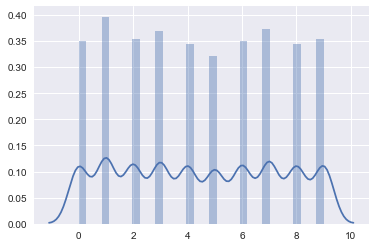

In [24]:
#Y_dist=pd.DataFrame(Y.label.value_counts())
#Y_dist = Y_dist.reset_index()
#Y_dist.columns = ['label','count']
#Y_dist = Y_dist.set_index('label').sort_index().reset_index()
sns.distplot(Y);

Split the data accordingly, test set of 40%

In [26]:
X_train, X_test,Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.4)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

((25200, 784), (25200, 1))
((16800, 784), (16800, 1))


Import and play around with basic neural network

In [27]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()
clf.fit(X_train,Y_train)

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:904: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [ ]:
%%bash
git add Handwritten_Neural.ipynb
git commit -m 'Will Add Neural Network params'
git push